In [2]:
# code based on: https://gist.github.com/francois-rozet/fd6a820e052157f8ac6e2aa39e16c1aa
# paper: "Flow Matching for Generative Modeling" https://arxiv.org/abs/2210.02747

import math
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
from tqdm import tqdm
from zuko.utils import odeint


def log_normal(x: Tensor) -> Tensor:
    return -(x.square() + math.log(2 * math.pi)).sum(dim=-1) / 2


class ode_wrapper(torch.nn.Module):
    """Wraps model to ode solver compatible format. Also important for solving various types of
    ODEs.

    Args:
        model (torch.nn.Module): Model to wrap.
        cond (torch.Tensor, optional): Condition. Defaults to None.
    """

    def __init__(
        self,
        model: nn.Module,
        cond: torch.Tensor = None,
    ):
        super().__init__()
        self.model = model
        self.cond = cond

    def forward(self, t, x):
        return self.model(t, x, cond=self.cond)


class MLP(nn.Sequential):
    """Simple MLP with ELU activation function."""

    def __init__(
        self,
        in_features: int,
        out_features: int,
        hidden_features: List[int] = [64, 64],
    ):
        layers = []

        for a, b in zip(
            [in_features] + hidden_features,
            hidden_features + [out_features],
        ):
            layers.extend([nn.Linear(a, b), nn.ELU()])

        super().__init__(*layers[:-1])


class CNF(nn.Module):
    """Continuous normalising flow model.

    This model represents the vector field v_t(x) from the paper.
    """

    def __init__(
        self,
        features: int,
        frequencies: int = 3,
        cond_features: int = 0,
        **kwargs,
    ):
        super().__init__()
        # NOTE: Instead of using one time dimension, we use n_frequencies * 2 time
        # dimensions (cos and sin of the frequencies)
        # --> e.g. for 3 frequencies f1, f2, f3, we have 6 "time values"
        #     [cos(f1*t), sin(f1*t), cos(f2*t), sin(f2*t), cos(f3*t), sin(f3*t)]
        self.net = MLP(2 * frequencies + features + cond_features, features, **kwargs)
        self.cond_features = cond_features

        self.register_buffer("frequencies", 2 ** torch.arange(frequencies) * torch.pi)

    def forward(self, t: Tensor, x: Tensor, cond: Tensor = None) -> Tensor:
        """The forward pass through this model represents the forward pass that is needed during
        flow matching training. This means that we compute the vector field v_t(x) for different
        samples of the batch x and different time values t.

        Parameters
        ----------
        t : Tensor
            Time dimension, shape (batch_size,)
        x : Tensor
            Input, shape (batch_size, features)
        cond : Tensor
            Conditional input, shape (batch_size, cond_features)
        """
        # NOTE: see comment in __init__ about the time dimension
        t = self.frequencies * t[..., None]  # (batch_size, n_frequencies)
        t = torch.cat((t.cos(), t.sin()), dim=-1)  # (batch_size, 2*n_frequencies)
        t = t.expand(*x.shape[:-1], -1)  # (batch_size, 2*n_frequencies) ?

        # (batch_size, 2*n_frequencies + features)
        net_input = (
            torch.cat((t, x, cond), dim=-1)
            if self.cond_features
            else torch.cat((t, x), dim=-1)
        )

        return self.net(net_input)

    def encode(self, x: Tensor, cond: Tensor = None, t_end: float = 1.0) -> Tensor:
        """Encode a sample x into the latent space z.

        Note: this is not needed during training.
        """
        return odeint(ode_wrapper(self, cond), x, 0.0, t_end, phi=self.parameters())

    def decode(self, z: Tensor, cond: Tensor = None, t_end: float = 0.0) -> Tensor:
        """Decode a latent sample z into the data space x.

        Note: this is not needed during training, but can be used to generate samples
        """
        return odeint(ode_wrapper(self, cond), z, 1.0, t_end, phi=self.parameters())

    def integrate(
        self, y: Tensor, cond: Tensor = None, t_start: float = 0.0, t_end: float = 1.0
    ) -> Tensor:
        """Integrate a sample y (something between x and z) from t_start to t_end.

        Note: t=0 corresponds to the data space x, t=1 corresponds to the latent space z.
        """
        return odeint(ode_wrapper(self, cond), y, t_start, t_end, phi=self.parameters())

    def log_prob(self, x: Tensor) -> Tensor:
        # get the identity matrix with shape (batch_size, features, features)
        identity = torch.eye(x.shape[-1], dtype=x.dtype, device=x.device)
        # move the last dimension to the first dimension
        identity = identity.expand(*x.shape, x.shape[-1]).movedim(-1, 0)

        def augmented(t: Tensor, x: Tensor, ladj: Tensor) -> Tensor:
            # helper function to compute the trace of the jacobian
            # t=time
            # x=input
            # ladj=log_abs_det_jacobian (not used here, but needed for the
            #     odeint function syntax)
            with torch.enable_grad():
                x = x.requires_grad_()
                vt = self(t, x)

            # vt = d(phi_t)/dt
            # jacobian = d(vt)/dx
            jacobian = torch.autograd.grad(
                vt, x, identity, create_graph=True, is_grads_batched=True
            )[0]
            # calculate the trace of the jacobian
            trace = torch.einsum("i...i", jacobian)

            return vt, trace * 1e-2  # 1e-2 is a scaling factor for numerical stability

        # initial value for the log_abs_det_jacobian (the subsequent contributions
        # are added to this value in the odeint call below)
        ladj = torch.zeros_like(x[..., 0])
        # integrate the augmented function from t=0 to t=1
        # --> returns the latent space z and the integral over the trace of the
        #     jacobian
        z, ladj = odeint(augmented, (x, ladj), 0.0, 1.0, phi=self.parameters())

        return log_normal(z) + ladj * 1e2  # rescale the ladj to undo the scaling above


class FlowMatchingLoss(nn.Module):
    """Implementation of the flow matching loss as explained in
    https://arxiv.org/abs/2210.02747."""

    def __init__(
        self,
        v: nn.Module,
        sigma_min: float = 1e-4,
        v_t_baseline: nn.Module = None,
    ):
        super().__init__()
        self.v = v
        self.sigma_min = sigma_min
        self.v_t_baseline = v_t_baseline

    def forward(self, x: Tensor, cond: Tensor = None) -> Tensor:
        # generate random time steps in the range [0, 1)
        # for each sample in the batch
        # (afterwards we use t = 1-t to get the range (0, 1])
        t = torch.rand_like(x[..., 0]).unsqueeze(-1)
        z = torch.randn_like(x)
        # paper: psi_t(x) = ( 1 - (1-sigma_min)*t ) * x + t * x1
        # --> replace t --> 1-t
        # psi_t(x) = ( 1 - (1-σ_min)*(1-t) ) * x + (1-t) * x1
        #          = (1-t) * x1 + (1 - (1-σ_min) + t*(1-σ_min)) * x
        #          = (1-t) * x1 + (σ_min + t*(1-σ_min)) * x
        # here: x=x1(paper), z=x(paper)
        # --> y = psi_t(z) = (1-t) * x + (σ_min + t*(1-σ_min)) * z
        y = (1 - t) * x + (self.sigma_min + (1 - self.sigma_min) * t) * z
        # u = d(psi_t)/dt
        u = (1 - self.sigma_min) * z - x

        # return the loss, which is the mean squared error between the target vector
        # field u_t(x) = d(psi_t)/dt and the vector field v_t(x) = d(phi_t)/dt
        if self.v_t_baseline is not None:
            v_t = self.v(t.squeeze(-1), y, cond) + self.v_t_baseline(
                t.squeeze(-1), y, cond
            )
        else:
            v_t = self.v(t.squeeze(-1), y, cond)
        return (v_t - u).square().mean()

CNF(
  (net): MLP(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
)


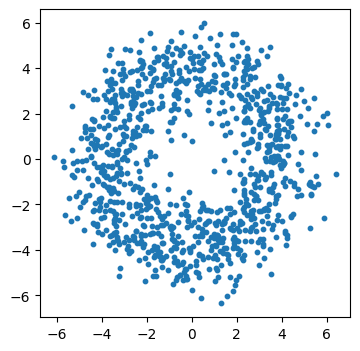

In [8]:
flow = CNF(features=2, hidden_features=[32] * 3)
print(flow)

from src.dataloader import *

sampler = multidim_sampler(2, "donut")
data = torch.Tensor(sampler.sample_data(1000))

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(data[:, 0], data[:, 1], s=10)

In [11]:
N_BATCHES = 100_000
# Training
fm_loss = FlowMatchingLoss(v=flow)
optimizer = torch.optim.AdamW(flow.parameters(), lr=1e-3)

pbar = tqdm(range(N_BATCHES), ncols=88)

for epoch in pbar:
    # select a random batch of the data
    subset = torch.randint(0, len(data), (100,))
    x = data[subset]

    # calculate the loss, i.e. E(u_t(x) - v_t(x))^2 for this batch and
    # perform a gradient step which brings the parameters of v_t(x) closer
    # to u_t(x)
    loss_this_batch = fm_loss(x)
    # loss_this_batch = -flow.log_prob(x).mean()

    optimizer.zero_grad()
    loss_this_batch.backward()
    optimizer.step()
    
    # add loss to pbar
    pbar.set_postfix(loss=f"{loss_this_batch.item():.2f}")

# Sampling
with torch.no_grad():
    z = torch.randn(4096, 2)
    x = flow.decode(z).numpy()

100%|█████████████████████████████████| 20000/20000 [00:51<00:00, 385.22it/s, loss=3.94]


100%|██████████| 70/70 [00:01<00:00, 41.98it/s]


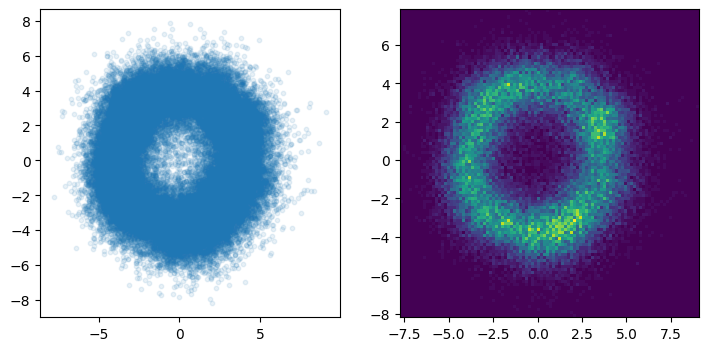

In [12]:
times = np.concatenate([np.linspace(0, 0.2, 40), np.linspace(0.2, 1, 30)])[::-1]

data_at_times = []
data_at_times_cc = []

with torch.no_grad():
    z = torch.randn(50000, 2)
    # for time in tqdm(times):
    #     x = flow.decode(z, t_end=time).numpy()
    #     data_at_times.append(x)
    t_start = 1
    y = z
    for time in tqdm(times):
        y = flow.integrate(y, t_start=t_start, t_end=time)
        t_start = time
        data_at_times.append(y.numpy())

fig, axarr = plt.subplots(1, 2, figsize=(8.5, 4))
ax = axarr[0]
# ax.scatter(data[:, 0], data[:, 1], s=10, alpha=0.1)
ax.scatter(data_at_times[-1][:, 0], data_at_times[-1][:, 1], s=10, alpha=0.1)
ax = axarr[1]
ax.hist2d(data_at_times[-1][:, 0], data_at_times[-1][:, 1], bins=100)
plt.show()

(70, 50000, 2)


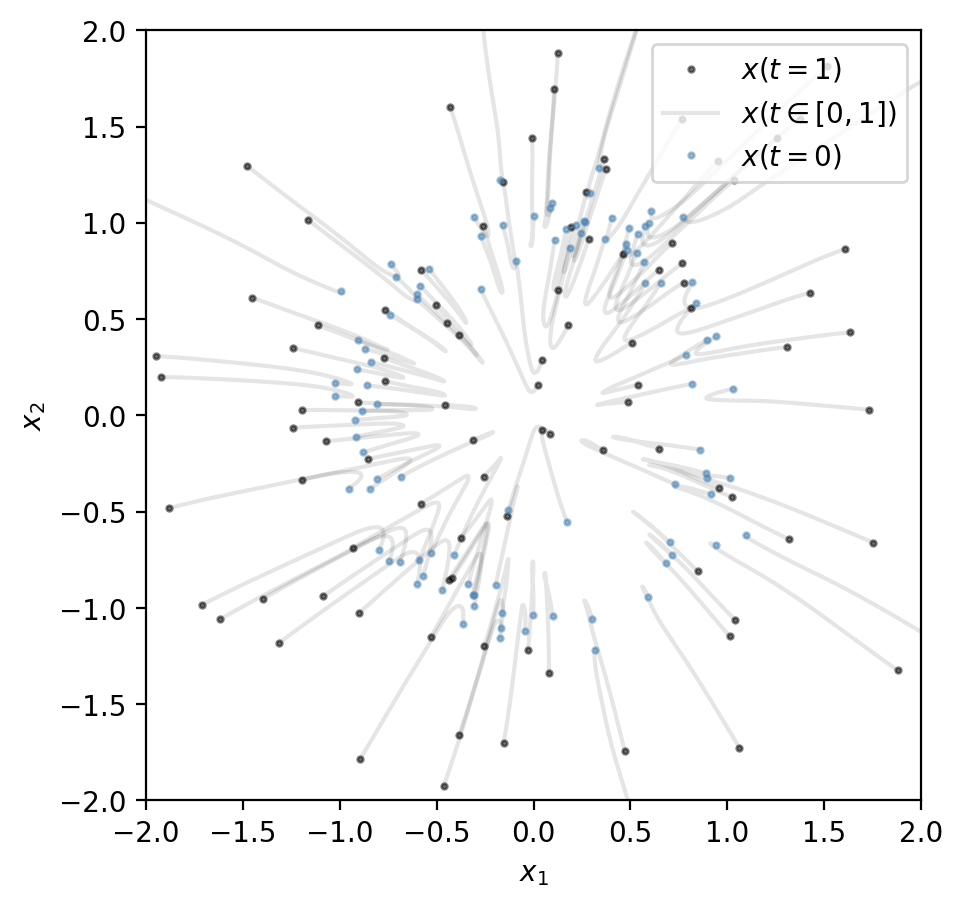

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

np_data_at_times = np.array(data_at_times)
print(np_data_at_times.shape)

style_t1 = dict(color="k", alpha=0.5, markersize=2, marker="o", label="$x(t=1)$", linestyle="None")
style_t0 = dict(
    color="steelblue", alpha=0.5, markersize=2, marker="o", label="$x(t=0)$", linestyle="None"
)
style_t = dict(color="k", alpha=0.1, markersize=2, linestyle="-")
n_plot = 100

ax.plot(np_data_at_times[0, :n_plot, 0], np_data_at_times[0, :n_plot, 1], **style_t1)
ax.plot(np_data_at_times[:, :n_plot, 0], np_data_at_times[:, :n_plot, 1], **style_t)
ax.plot([], [], **style_t, label="$x(t\\in [0, 1])$")
ax.plot(np_data_at_times[-1, :n_plot, 0], np_data_at_times[-1, :n_plot, 1], **style_t0)

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

ax.legend(loc="upper right")

plt.show()